# Auteurs:
*   Arnaud Dalbec-Constant: 2014288
*   Félix Auger: 2067772



In [ ]:
from google.colab import drive
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import time
import os, os.path
import pandas as pd
from scipy.spatial.distance import euclidean
from sklearn.neighbors import KNeighborsClassifier

drive.mount('/content/drive')

Mounted at /content/drive


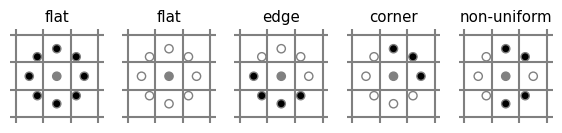

In [ ]:
METHOD = 'uniform'
plt.rcParams['font.size'] = 9

def plot_circle(ax, center, radius, color):
    circle = plt.Circle(center, radius, facecolor=color, edgecolor='0.5')
    ax.add_patch(circle)

def plot_lbp_model(ax, binary_values):
    """Draw the schematic for a local binary pattern."""
    # Geometry spec

    theta = np.deg2rad(45)
    R = 1
    r = 0.15
    w = 1.5
    gray = '0.5'

    # Draw the central pixel.
    plot_circle(ax, (0, 0), radius=r, color=gray)
    # Draw the surrounding pixels.
    for i, facecolor in enumerate(binary_values):
        x = R * np.cos(i * theta)
        y = R * np.sin(i * theta)
        plot_circle(ax, (x, y), radius=r, color=str(facecolor))

    # Draw the pixel grid.
    for x in np.linspace(-w, w, 4):
        ax.axvline(x, color=gray)
        ax.axhline(x, color=gray)

    # Tweak the layout.
    ax.axis('image')
    ax.axis('off')
    size = w + 0.2
    ax.set_xlim(-size, size)
    ax.set_ylim(-size, size)

fig, axes = plt.subplots(ncols=5, figsize=(7, 2))

titles = ['flat', 'flat', 'edge', 'corner', 'non-uniform']

binary_patterns = [np.zeros(8),
                   np.ones(8),
                   np.hstack([np.ones(4), np.zeros(4)]),
                   np.hstack([np.zeros(3), np.ones(5)]),
                   [1, 0, 0, 1, 1, 1, 0, 0]]

for ax, values, name in zip(axes, binary_patterns, titles):
    plot_lbp_model(ax, values)
    ax.set_title(name)

In [ ]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

path_boxed_test = "/content/drive/MyDrive/INF6804/TP1_boxed_data/"
path_test = "/content/drive/MyDrive/INF6804/TP1_data/"
path = "/content/drive/MyDrive/INF6804/TP1_data/database"
boxed_path = "/content/drive/MyDrive/INF6804/TP1_boxed_data/database"

# settings for LBP
# Best hyperparameters found in Gridsearch
radius = 4
n_points = 4 * radius

def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)

def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')

def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))


# Creation of LBP dataset from dataset images
# Generate best 3 predictions for every test image



In [ ]:
def train_df_generation(path):
  lbp_dataframe = pd.DataFrame(columns = ['Image','Image_type','LBP'])
  for image in os.listdir(path):
    image_path = path + '/' + image
    im = cv2.imread(image_path)
    im_gray = np.mean(im, axis=2)

    lbp = local_binary_pattern(im_gray, n_points, radius, METHOD)

    values, lbp_hist = np.unique(lbp.ravel(), return_counts = True)
    lbp_hist = lbp_hist / np.size(im_gray) # normalize by the size of the image
    lbp_dataframe.loc[len(lbp_dataframe.index)] = [image, image[:-6], lbp_hist]
  return lbp_dataframe

def generate_LBP_3_best_results(path_test, lbp_dataframe):

  # KNN classifier with 1 neighbors
  X = lbp_dataframe['LBP'].tolist()
  y = lbp_dataframe['Image_type'].tolist()
  #Three are being evaluated for top 3, but the prediction is based on the neareast neighbor
  neigh = KNeighborsClassifier(n_neighbors = 3)
  neigh.fit(X, y)

  valid_images = [".jpg",".png"]
  test_dataframe = pd.DataFrame(columns=
          ['test_image',
           'LBP_pred_KNN',
           'LBP_pred_KB',
           'is_pred_true_KNN',
           'is_pred_true_KB',
           'KB_3_best',
           'KNN_3_best',
           'LBP'])

  index = 0
  start_time = time.time()
  for image in os.listdir(path_test):
    image_path = path_test + '/' + image

    if os.path.splitext(image_path)[1] == ".jpg":
      im_current = cv2.imread(image_path)

      # Preprocessing
      current_im_gray = np.mean(im_current, axis=2)
      # Preprocessing with brightness increase
      """
      brightness_factor = 50
      current_im_gray = np.mean(im_current, axis=2)
      current_im_gray = np.clip(current_im_gray + brightness_factor, 0, 255)
      """

      index += 1
      plt.subplot(1, 9, index)
      plt.imshow(current_im_gray, cmap='gray')
      plt.gca().set_axis_off()

      # LBP
      current_lbp = local_binary_pattern(current_im_gray, n_points, radius, METHOD)
      values, lbp_hist = np.unique(current_lbp.ravel(), return_counts = True)
      lbp_hist = lbp_hist / np.size(current_im_gray) # normalize by the size of the image

      # Kullback Leibler Divergence score
      best_score = 1e8
      second_best_score = 1e8
      third_best_score = 1e8
      third_best_name = None
      second_best_name = None
      best_name = None
      for i in lbp_dataframe.index:
          lbp_ref_hist = lbp_dataframe['LBP'][i]
          label_ref = lbp_dataframe['Image_type'][i]

          score = kullback_leibler_divergence(lbp_hist, lbp_ref_hist)
          if (score < best_score):
              third_best_score = second_best_score
              second_best_score = best_score
              best_score = score
              third_best_name = second_best_name
              second_best_name = best_name
              best_name = label_ref

          elif (score < second_best_score):
              third_best_score = second_best_score
              second_best_score = score
              third_best_name = second_best_name
              second_best_name = label_ref

          elif (score < third_best_score):
              third_best_score = score
              third_best_name = label_ref

      # Classification
      distances, indices = neigh.kneighbors([lbp_hist])
      top_3_predictions = np.array([lbp_dataframe['Image_type'][i] for i in indices])
      test_dataframe.loc[len(test_dataframe.index)] = [image, top_3_predictions[0][0], best_name, top_3_predictions[0][0] in image, best_name in image, [best_name, second_best_name, third_best_name],top_3_predictions[0], lbp_hist]

  print('Execution time (s):')
  print(time.time() - start_time)
  print(test_dataframe[['test_image','LBP_pred_KNN','is_pred_true_KNN','LBP_pred_KB','is_pred_true_KB','KB_3_best','KNN_3_best']])
  Accuracy = test_dataframe['is_pred_true_KNN'].sum() / len(test_dataframe.index) * 100
  print(f'The prediction accuracy with K-NN classifier is ' + str(Accuracy.astype(np.float16)) + '%')
  Accuracy = test_dataframe['is_pred_true_KB'].sum() / len(test_dataframe.index) * 100
  print(f'The prediction accuracy with Kullback is ' + str(Accuracy.astype(np.float16)) + '%')
  plt.show()
  return test_dataframe


2.052760124206543
             test_image LBP_pred_KNN  is_pred_true_KNN LBP_pred_KB  \
0  strawberry_query.jpg      dolphin             False     dolphin   
1    airplane_query.jpg         face             False        face   
2        ball_query.jpg        lotus             False       lotus   
3         car_query.jpg          car              True         car   
4         cat_query.jpg          cat              True         cat   
5     dolphin_query.jpg          car             False         car   
6        face_query.jpg         face              True        face   
7       lotus_query.jpg         ball             False        ball   
8     pickles_query.jpg     airplane             False    airplane   

   is_pred_true_KB                      KB_3_best  \
0            False   [dolphin, dolphin, airplane]   
1            False              [face, car, face]   
2            False          [lotus, dolphin, cat]   
3             True              [car, face, face]   
4             Tr

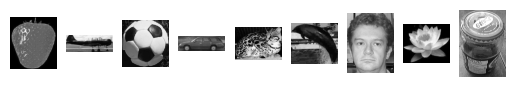

2.750633716583252
             test_image LBP_pred_KNN  is_pred_true_KNN LBP_pred_KB  \
0  strawberry_query.jpg      pickles             False     pickles   
1    airplane_query.jpg     airplane              True    airplane   
2        ball_query.jpg         ball              True        ball   
3         car_query.jpg          car              True         car   
4         cat_query.jpg          cat              True         cat   
5     dolphin_query.jpg          cat             False         cat   
6        face_query.jpg         face              True        face   
7       lotus_query.jpg      pickles             False        ball   
8     pickles_query.jpg      pickles              True     pickles   

   is_pred_true_KB                    KB_3_best                   KNN_3_best  
0            False  [pickles, pickles, pickles]  [pickles, pickles, pickles]  
1             True    [airplane, car, airplane]    [airplane, airplane, car]  
2             True    [ball, airplane, dolph

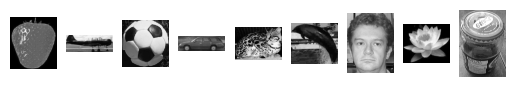

In [ ]:
lbp_dataframe = train_df_generation(path)
boxed_lbp_dataframe = train_df_generation(boxed_path)

test_dataframe = generate_LBP_3_best_results(path_test, lbp_dataframe)
boxed_test_dataframe = generate_LBP_3_best_results(path_boxed_test, boxed_lbp_dataframe)

In [ ]:
test_dataframe.to_csv('/content/drive/MyDrive/INF6804/best_results_LBP.csv')
boxed_test_dataframe.to_csv('/content/drive/MyDrive/INF6804/best_results_LBP_boxed.csv')

## Functions for grid search with radius and n_points sweep

In [ ]:
def generate_LBP_results(path_test, lbp_dataframe):
  # KNN classifier with 5 neighbors
  X = lbp_dataframe['LBP'].tolist()
  y = lbp_dataframe['Image_type'].tolist()
  #__________________________________________________
  # Hyperparameter to play with (n_neighbors)
  neigh = KNeighborsClassifier(n_neighbors = 3)
  neigh.fit(X, y)
  #__________________________________________________
  valid_images = [".jpg",".png"]
  test_dataframe = pd.DataFrame(columns=
          ['test_image',
           'LBP_pred_KNN',
           'LBP_pred_KB',
           'is_pred_true_KNN',
           'is_pred_true_KB',
           'LBP'])

  for image in os.listdir(path_test):
    image_path = path_test + '/' + image

    if os.path.splitext(image_path)[1] == ".jpg":
      im_current = cv2.imread(image_path)

      # Preprocessing
      current_im_gray = np.mean(im_current, axis=2)

      # LBP
      current_lbp = local_binary_pattern(current_im_gray, n_points, radius, METHOD)
      values, lbp_hist = np.unique(current_lbp.ravel(), return_counts = True)
      lbp_hist = lbp_hist / np.size(current_im_gray) # normalize by the size of the image

      # Kullback Leibler Divergence score
      best_score = 1e8
      for i in lbp_dataframe.index:
          lbp_ref_hist = lbp_dataframe['LBP'][i]
          label_ref = lbp_dataframe['Image_type'][i]

          score = kullback_leibler_divergence(lbp_hist, lbp_ref_hist)
          if score < best_score:
              best_score = score
              best_name = label_ref

      # Classification
      label_pred = str(neigh.predict([lbp_hist])[0])
      test_dataframe.loc[len(test_dataframe.index)] = [image, label_pred, best_name, label_pred in image, best_name in image, lbp_hist]

  print(test_dataframe[['test_image','LBP_pred_KNN','is_pred_true_KNN','LBP_pred_KB','is_pred_true_KB']])
  Accuracy = test_dataframe['is_pred_true_KNN'].sum() / len(test_dataframe.index) * 100
  print(f'The prediction accuracy with K-NN classifier is ' + str(Accuracy.astype(np.float16)) + '%')
  Accuracy = test_dataframe['is_pred_true_KB'].sum() / len(test_dataframe.index) * 100
  print(f'The prediction accuracy with Kullback is ' + str(Accuracy.astype(np.float16)) + '%')
  return test_dataframe


# Grid Search for hyperparameters analysis
## Run only to compare all combinations of hyperparameters

In [ ]:
# Hyperparameters list
radius_list = [2,4,6,8]
n_points_list = [4, 6, 8, 10]

result_df = pd.DataFrame(columns = ['radius', 'n_points', 'Acc_KNN', 'Acc_KB', 'box_Acc_KNN','box_Acc_KB'])
for radius in radius_list:
  for n_points in n_points_list:
      n_points = n_points * radius
      print(f'running with hyperparameters: radius:{radius} and n_points:{n_points}')
      lbp_dataframe = train_df_generation(path)
      boxed_lbp_dataframe = train_df_generation(boxed_path)

      test_dataframe = generate_LBP_results(path_test, lbp_dataframe)
      boxed_test_dataframe = generate_LBP_results(path_boxed_test, boxed_lbp_dataframe)

      Accuracy_KNN = test_dataframe['is_pred_true_KNN'].sum() / len(test_dataframe.index) * 100
      Accuracy_KB = test_dataframe['is_pred_true_KB'].sum() / len(test_dataframe.index) * 100
      boxed_Accuracy_KNN = boxed_test_dataframe['is_pred_true_KNN'].sum() / len(boxed_test_dataframe.index) * 100
      boxed_Accuracy_KB = boxed_test_dataframe['is_pred_true_KB'].sum() / len(boxed_test_dataframe.index) * 100

      result_df.loc[len(result_df.index)] = [radius,
                                             n_points,
                                             Accuracy_KNN,
                                             Accuracy_KB,
                                             boxed_Accuracy_KNN,
                                             boxed_Accuracy_KB]



In [ ]:
# Save results as CSV
result_df.to_csv('/content/drive/MyDrive/INF6804/Hyperparameter_gridsearch_LBP_KNN3.csv')

# GridSearch visualization

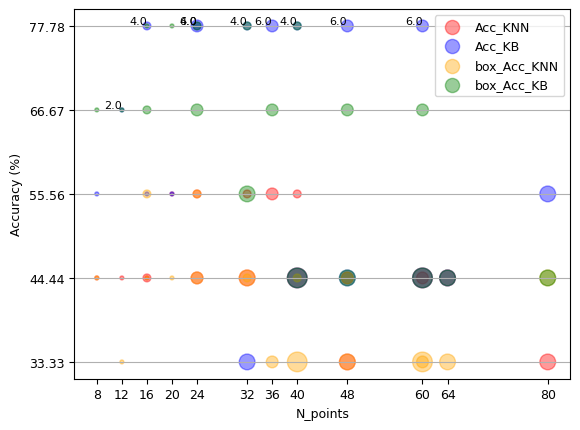

In [ ]:
colors = {
    'Acc_KNN': 'red',
    'Acc_KB': 'blue',
    'box_Acc_KNN': 'orange',
    'box_Acc_KB': 'green'
}
plt.scatter(result_df['n_points'], result_df['Acc_KNN'], label='Acc_KNN',s=2*(result_df['radius'])**2,color = colors['Acc_KNN'],alpha = 0.4)
plt.scatter(result_df['n_points'], result_df['Acc_KB'], label='Acc_KB',s=2*(result_df['radius'])**2,color = colors['Acc_KB'],alpha = 0.4)
plt.scatter(result_df['n_points'], result_df['box_Acc_KNN'], label='box_Acc_KNN',s=2*(result_df['radius'])**2,color = colors['box_Acc_KNN'],alpha = 0.4)
plt.scatter(result_df['n_points'], result_df['box_Acc_KB'], label='box_Acc_KB',s=2*(result_df['radius'])**2,color = colors['box_Acc_KB'],alpha = 0.4)
plt.xlabel('N_points')
plt.ylabel('Accuracy (%)')
unique_y_values = pd.concat([
    result_df['Acc_KNN'],
    result_df['Acc_KB'],
    result_df['box_Acc_KNN'],
    result_df['box_Acc_KB']
]).unique()
unique_x_values = result_df['n_points'].unique()
plt.yticks(unique_y_values)
plt.xticks(unique_x_values)
plt.grid(which='both', axis='y')
plt.legend()

texts = []
for i, txt in enumerate(result_df.iterrows()):
    if txt[1]['Acc_KNN'] >= 60:
        plt.text(txt[1]['n_points'], txt[1]['Acc_KNN'], f"{txt[1]['radius']}", ha='right', va='bottom', color='black', fontsize=8)
    if txt[1]['Acc_KB'] >= 60:
        plt.text(txt[1]['n_points'], txt[1]['Acc_KB'], f"{txt[1]['radius']}", ha='right', va='bottom', color='black', fontsize=8)

plt.show()

# TESTS

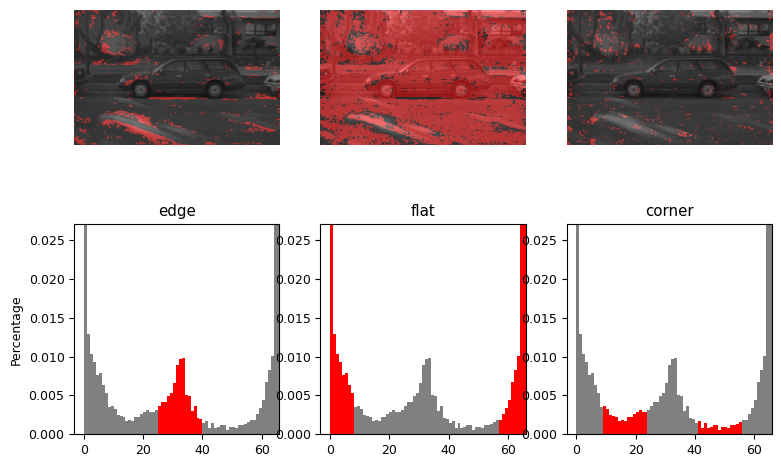

In [ ]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

# settings for LBP
radius = 8
n_points = 8 * radius

image = cv2.imread("/content/drive/MyDrive/INF6804/TP1_data/car_query.jpg")
image_gray = np.mean(image, axis=2)
lbp = local_binary_pattern(image_gray, n_points, radius, METHOD)

def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')

# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)


for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

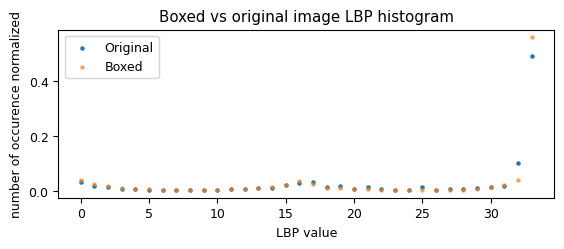

In [ ]:
image_path = "/content/drive/MyDrive/INF6804/TP1_data/airplane_query.jpg"
boxed_image_path = "/content/drive/MyDrive/INF6804/TP1_boxed_data/airplane_query.jpg"

im = cv2.imread(image_path)
im_gray = np.mean(im, axis=2)
boxed_im = cv2.imread(boxed_image_path)
boxed_im_gray = np.mean(boxed_im, axis=2)

lbp = local_binary_pattern(im_gray, n_points, radius, METHOD)
boxed_lbp = local_binary_pattern(boxed_im_gray, n_points, radius, METHOD)

values, lbp_hist = np.unique(lbp.ravel(), return_counts = True)
lbp_hist = lbp_hist / np.size(im_gray) # normalize by the size of the image
boxed_values, boxed_lbp_hist = np.unique(boxed_lbp.ravel(), return_counts = True)
boxed_lbp_hist = boxed_lbp_hist / np.size(boxed_im_gray) # normalize by the size of the image
plt.subplot(2,1,1)
plt.scatter(values,lbp_hist,label = 'Original', alpha = 1, s = 5)
plt.scatter(boxed_values, boxed_lbp_hist,label = 'Boxed', alpha = 0.6, s = 5)
plt.title('Boxed vs original image LBP histogram')
plt.xlabel('LBP value')
plt.ylabel('number of occurence normalized')
plt.legend()

plt.show()